In [1]:
from model import Deeplab3P
from data import get_cityscapes,get_pascal_voc
import datetime
import time

import torch
import torch.utils.data
from torch import nn
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:

class ConfusionMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, a, b):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=a.device)
        with torch.no_grad():
            k = (a >= 0) & (a < n)
            inds = n * a[k].to(torch.int64) + b[k]
            self.mat += torch.bincount(inds, minlength=n**2).reshape(n, n)

    def reset(self):
        self.mat.zero_()

    def compute(self):
        h = self.mat.float()
        acc_global = torch.diag(h).sum() / h.sum()
        acc = torch.diag(h) / h.sum(1)
        iu = torch.diag(h) / (h.sum(1) + h.sum(0) - torch.diag(h))
        return acc_global, acc, iu
    def __str__(self):
        acc_global, acc, iu = self.compute()
        return (
            'global correct: {:.1f}\n'
            'average row correct: {}\n'
            'IoU: {}\n'
            'mean IoU: {:.1f}').format(
            acc_global.item() * 100,
            ['{:.1f}'.format(i) for i in (acc * 100).tolist()],
            ['{:.1f}'.format(i) for i in (iu * 100).tolist()],
            iu.mean().item() * 100)


def criterion2(inputs, target, w):
    return nn.functional.cross_entropy(inputs,target,ignore_index=255)
# def criterion(inputs, target, w):
#     losses = {}
#     for name, x in inputs.items():
#         losses[name] = nn.functional.cross_entropy(x, target, weight=w,ignore_index=255)
#
#     if len(losses) == 1:
#         return losses['out']
#
#     return losses['out'] + 0.5 * losses['aux']

# def mixup(x,device):
#     assert len(x.size())==4
#     batch_size = x.size()[0]
#     index = torch.randperm(batch_size).to(device)
#     lam=0.9
#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     return mixed_x




In [3]:
    device = torch.device(
        'cuda') if torch.cuda.is_available() else torch.device('cpu')
    num_classes = 21
    batch_size=1
    pretrained_path='./content/finalsave'
    data_loader, data_loader_test=get_pascal_voc("pascal_voc_dataset",batch_size)
    eval_steps = len(data_loader_test)
    model=Deeplab3P(name="regnetx_040",num_classes=num_classes,pretrained=pretrained_path).to(
        device)


train size: 10582
val size: 1449


In [4]:
    model.eval()
    confmat = ConfusionMatrix(num_classes)
    with torch.no_grad():
        for i,(image, target) in enumerate(data_loader):
            print(i+1)
            image2, target2 = image.to(device), target.to(device)
            output = model(image2)
            confmat.update(target2.flatten(), output.argmax(1).flatten())
            if i==0:
                break


1


In [5]:
a = output.argmax(1)
a

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')

In [6]:
b = a.cpu().detach().numpy()
c = b.squeeze()
b.shape, c.shape

((1, 481, 481), (481, 481))

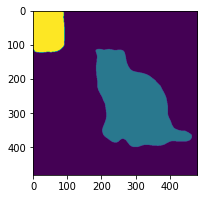

In [7]:
plt.figure(figsize=(10,10));
plt.subplot(133);
plt.imshow(c);

In [8]:
im1 = image.squeeze()
im2 = im1.squeeze()
im2.shape

torch.Size([3, 481, 481])

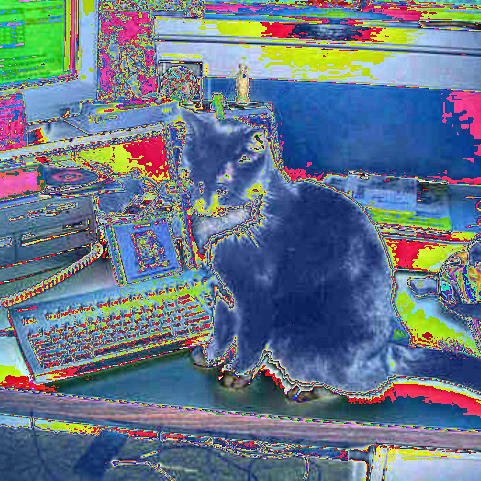

In [15]:
im = transforms.ToPILImage()(im2)
im

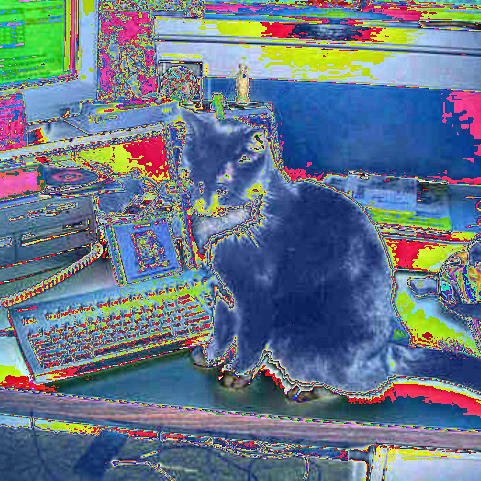

In [11]:
im